In [1]:
%matplotlib ipympl
import numpy as np
import sys

# setting path for mask_utils package
sys.path.append('..')

from mask_utils.imaging_utils import  decode, decode_var, generate_bulk, get_openfraction,  get_skysign, get_skycoords, get_detimage_edges, get_detimage
from mask_utils.fits_utils import read_mask_bulk, read_fits_events
from mask_utils.image_utils import upscale, fshift, ferosion, apply_vignetting
from mask_utils.other_utils import filter_source
from scipy.signal import convolve
from scipy.ndimage import center_of_mass
from scipy.ndimage import shift as ndshift
from scipy.ndimage import gaussian_filter as gaussian_filter
from functools import lru_cache
from scipy.optimize import least_squares
import timeit

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
mask_file = "mask_050_1040x17_20250725.fits"

In [3]:
mask, hdmask = read_mask_bulk(mask_file, 2, header_out=True, verbose=False)
rmatrix = read_mask_bulk(mask_file, 3, verbose=False)
bulk = read_mask_bulk(mask_file, 4, verbose=False)

In [4]:
#Gets mask information and define X, Y vectors (centers and edges)
ELXDIM = hdmask['ELXDIM'] 
ELYDIM = hdmask['ELYDIM'] 
ELXN   = hdmask['ELXN'] 
ELYN   = hdmask['ELYN']
MTHICK = 0.150
focal  = 202.9 + MTHICK

In [5]:
def wfm_psfy(y):
    center, alpha, beta, sigma = 0, 0.5459735904725987, 0.7363355668833482, 0.17749677955602094 #good for both cameras on ScoX-1
    psf = 1 / np.cosh(np.abs(( y - center) / alpha) ** beta) 
    psf = gaussian_filter(psf, sigma, mode='constant', cval=0)
    
    return psf/np.sum(psf)

# Removing fractional bulk elements to simplify the analysis
# and eroding bulk to remove not properly reconstructed regions

In [6]:
bulk[bulk < 1] = 0
bulk_eroded  = ferosion( bulk.T, 1.5/ELYDIM, 1).T
bulk_eroded  = ferosion( bulk_eroded.T, -1.5/ELYDIM, 1).T
bulk = bulk_eroded

In [7]:
#Upscaling mask, rmatrix, bulk
up_f_x, up_f_y = 2.0, 1.0

mask = upscale(mask, up_f_y, up_f_x)
rmatrix = upscale(rmatrix, up_f_y, up_f_x)
bulk = upscale(bulk, up_f_y, up_f_x)

ELXDIM /= up_f_x
ELYDIM /= up_f_y
ELXN   *= up_f_x
ELYN   *= up_f_y

In [8]:
filein = r"F:\CodedMasks\Simulations\galctr_rxte-sax_2-50keV_mask_050_1040x17_opaquemask_infdet\cam1a\galctr_rxte-sax_2-50keV_mask_050_1040x17_opaquemask_infdet_cam1a_reconstructed.fits"

if "reconstructed" in filein:
    datatype="reconstructed"
else:
    datatype = "detected"

print(datatype)

reconstructed


In [9]:
det, hdet0, hdet1 = read_fits_events(filein, header0=True, header1=True, verbose=False)

ra, dec = 244.979705810547, -15.6400995254517 #Sco X-1
#det = filter_source(det, ra, dec, verbose=True)

xedges, yedges = get_detimage_edges(ELXDIM, ELYDIM, ELXN, ELYN)

#Computes detector image
detimage_sim = get_detimage(det, xedges, yedges) * bulk
detimage_iros = np.zeros(detimage_sim.shape)

In [10]:
detimage_sim -= detimage_iros
skysim = decode(detimage_sim, rmatrix, bulk)

peak = np.max(skysim)
peak_p = np.unravel_index(np.argmax(skysim), skysim.shape)

In [11]:
xspan = int(0.25/ELXDIM)
yspan = int(15.5/ELYDIM)

labels = np.zeros(skysim.shape)
labels[peak_p[0] - xspan : peak_p[0] + xspan + 1 , peak_p[1] - yspan : peak_p[1] + yspan + 1] = 1

com = center_of_mass(skysim, labels=labels, index=1)
cx, cy = (skysim.shape[0] - 1 ) // 2, (skysim.shape[1] - 1 ) // 2
shiftX, shiftY = cx - com[0], cy - com[1]

print("Peak Center Of Mass:", com[0], com[1])
print("ShiftX [px]:", shiftX)
print("ShiftY [px]:", shiftY)
print("ShiftX [deg]:", -np.rad2deg(np.arctan((shiftX*ELXDIM)/(focal))))
print("ShiftY [deg]:", -np.rad2deg(np.arctan((shiftY*ELYDIM)/focal)))
print("ShiftX [mm]:", -shiftX * ELXDIM)
print("ShiftY [mm]:", -shiftY * ELYDIM)


Peak Center Of Mass: 2430.1534106966656 676.3593897244333
ShiftX [px]: -351.15341069666556
ShiftY [px]: -155.3593897244333
ShiftX [deg]: 12.198170226816135
ShiftY [deg]: 20.935069760147435
ShiftX [mm]: 43.894176337083195
ShiftY [mm]: 77.67969486221665


In [12]:
ypsf = np.arange(-yspan, yspan+1) * ELYDIM
psf =  wfm_psfy(ypsf).reshape(len(ypsf), -1).T

In [13]:
@lru_cache(maxsize=None)
def model_source(xsh, ysh, fluence):
    _shifted = fshift(mask, xsh, ysh)
    _vignetted = apply_vignetting(_shifted, xsh, ysh, focal, ELXDIM, ELYDIM, MTHICK)

    if datatype == "reconstructed":
        _detimage = convolve(_vignetted, psf, mode="same") * bulk
    else:
        _detimage = _vignetted * bulk
        
    _detimage_norm = _detimage/np.sum(_detimage)
    
    return(_detimage_norm * fluence)

In [14]:
peak_p = np.unravel_index(np.argmax(skysim), skysim.shape)
appo =  skysim[peak_p[0] - 2*xspan:peak_p[0] + 2*xspan - 1 , peak_p[1]-2*yspan: peak_p[1]+2*yspan -1]
def loss(args):
    sx, sy, fl = args[0], args[1], args[2]
    sky = decode(model_source(sx, sy, fl), rmatrix, bulk)
    # normalized error
    diff = np.sum( np.square(appo -  sky[peak_p[0] - 2*xspan:peak_p[0] + 2*xspan - 1 , peak_p[1]-2*yspan: peak_p[1]+2*yspan -1])) / fl
    
    return diff

In [15]:
_fluence = peak/0.90
print(_fluence)

1072288.4937243115


In [16]:
bnds = [(shiftX-2, shiftY-2, peak), (shiftX+2, shiftY+2, peak/0.8)]

start_time = timeit.default_timer()
results = least_squares(loss, [shiftX, shiftY, _fluence], bounds = bnds, method="trf", xtol=1e-4, ftol=1e-3, x_scale='jac') #x_scale='jac' needed for convergence
elapsed = timeit.default_timer() - start_time
print("Elapsed time", elapsed)
print(results)
print(results.x)

Elapsed time 24.00332299998263
     message: Both `ftol` and `xtol` termination conditions are satisfied.
     success: True
      status: 4
         fun: [ 2.637e+03]
           x: [-3.513e+02 -1.561e+02  1.052e+06]
        cost: 3476565.963010852
         jac: [[-1.811e+03  1.957e+02 -2.681e-04]]
        grad: [-4.775e+06  5.161e+05 -7.070e-01]
  optimality: 10189083.58357911
 active_mask: [0 0 0]
        nfev: 13
        njev: 9
[-3.51287203e+02 -1.56088647e+02  1.05246142e+06]


In [17]:
detimage_iros = model_source(results.x[0], results.x[1], results.x[2])
skyiros = decode(detimage_iros, rmatrix, bulk)

ScoX1_ThetaX = 12.20227
ScoX1_ThetaY = 21.02514

ThetaX = -np.rad2deg(np.arctan((results.x[0]*ELXDIM)/(focal)))
ThetaY = -np.rad2deg(np.arctan((results.x[1]*ELYDIM)/(focal)))

print("ShiftX [deg], errX [arcmin]:", ThetaX, (ThetaX - ScoX1_ThetaX) * 60)
print("ShiftY [deg], errX [arcmin]:", ThetaY, (ThetaY - ScoX1_ThetaY) * 60)

ShiftX [deg], errX [arcmin]: 12.202678591692155 0.02451550152930082
ShiftY [deg], errX [arcmin]: 21.024769336313945 -0.022239821163339002


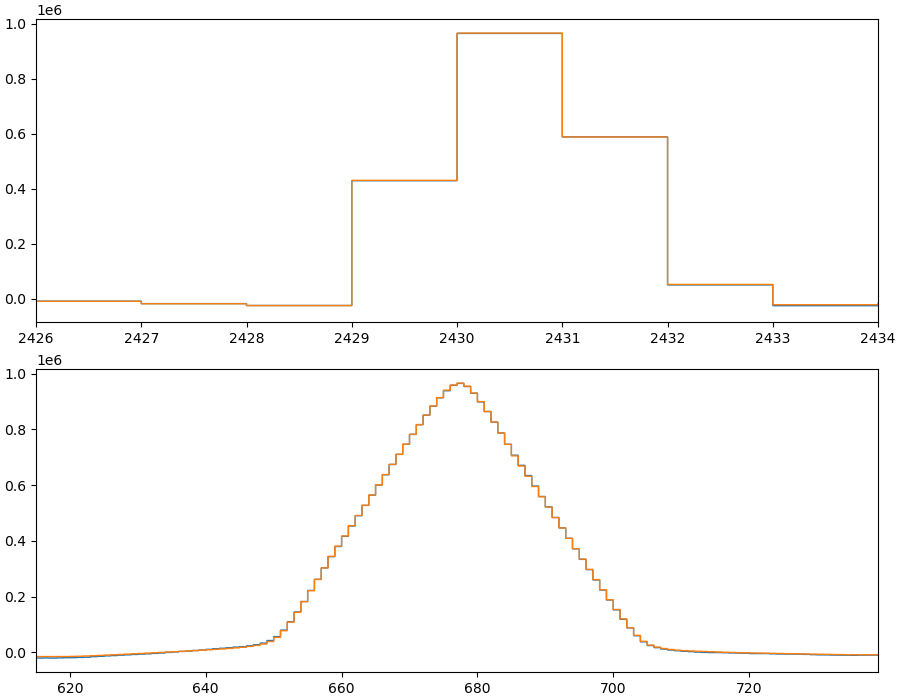

In [18]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(9, 7))
axs[0].set_title('')
axs[0].stairs(skysim[:, peak_p[1]])
axs[0].stairs(skyiros[:, peak_p[1]])

axs[0].set_xlim( (peak_p[0] - 2*xspan , peak_p[0] + 2*xspan))


axs[1].set_title('')
axs[1].stairs(skysim[peak_p[0], :])
axs[1].stairs(skyiros[peak_p[0], :])

axs[1].set_xlim( (peak_p[1] - 2*yspan , peak_p[1] + 2*yspan))

plt.show()

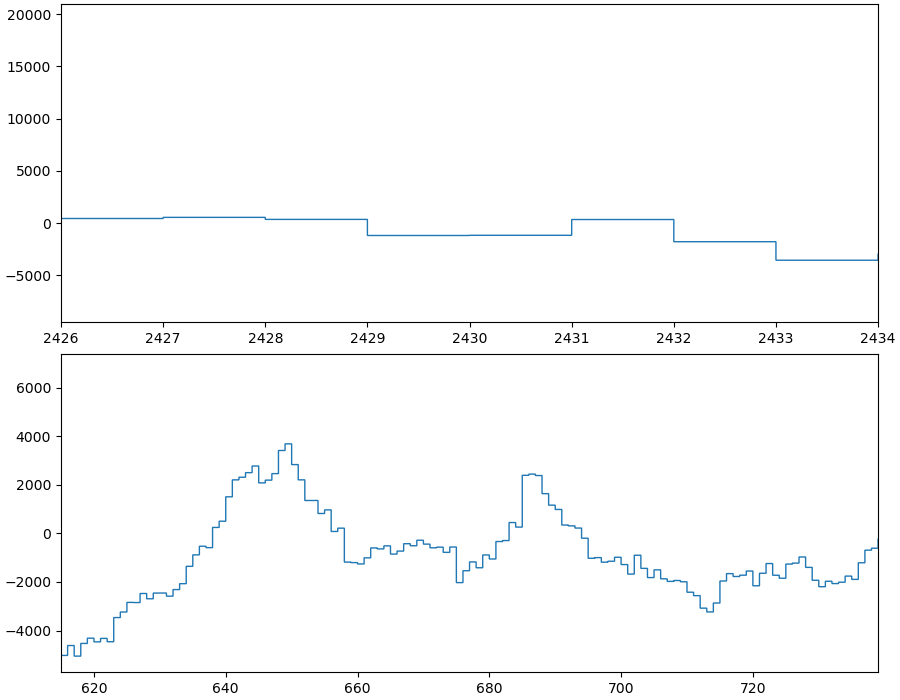

In [19]:
skydiff = decode(detimage_sim - detimage_iros, rmatrix, bulk)

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(9, 7))
axs[0].set_title('')
axs[0].stairs(skydiff[:, peak_p[1]])
axs[0].set_xlim( (peak_p[0] - 2*xspan , peak_p[0] + 2*xspan))

axs[1].set_title('')
axs[1].stairs(skydiff[peak_p[0], :])
axs[1].set_xlim( (peak_p[1] - 2*yspan , peak_p[1] + 2*yspan))

plt.show()

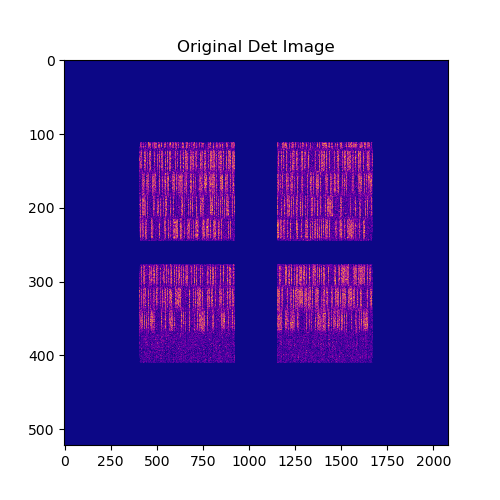

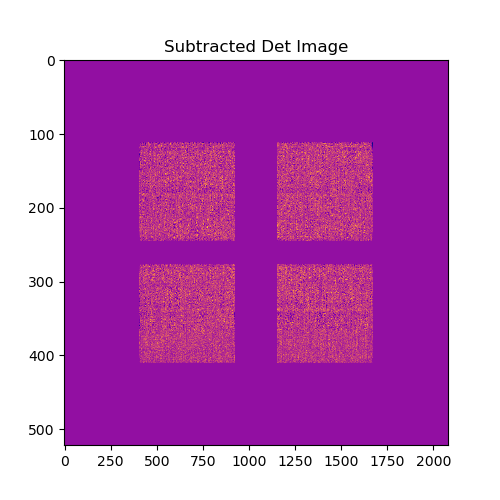

In [20]:
plt.figure(figsize=(5, 5))
plt.title("Original Det Image")
plt.imshow(detimage_sim.T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

plt.figure(figsize=(5, 5))
plt.title("Subtracted Det Image")
plt.imshow(detimage_sim.T - detimage_iros.T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()


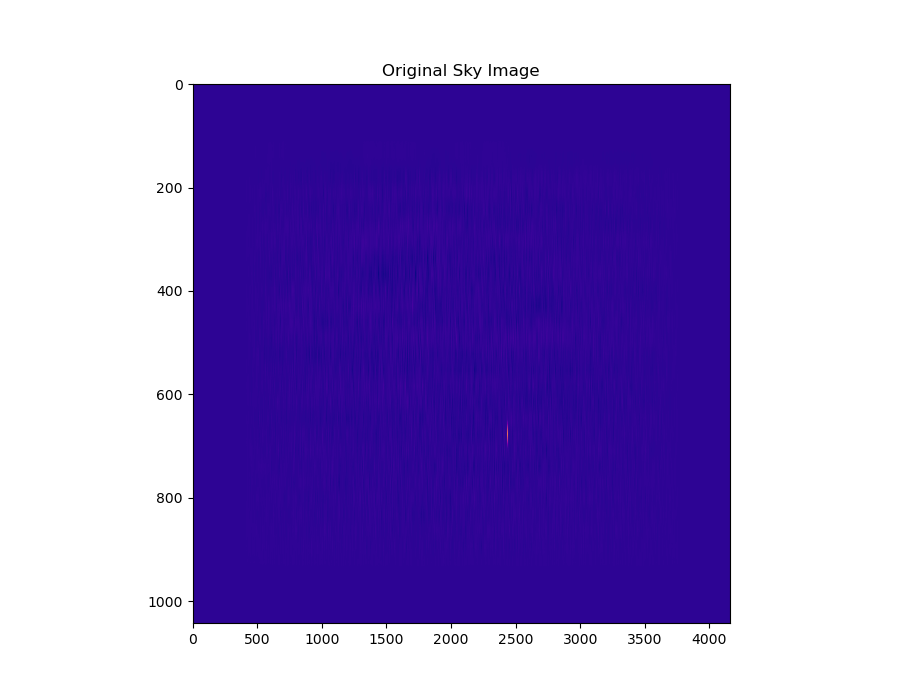

In [21]:
plt.figure(figsize=(9, 7))
plt.title("Original Sky Image")
plt.imshow(skysim.T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

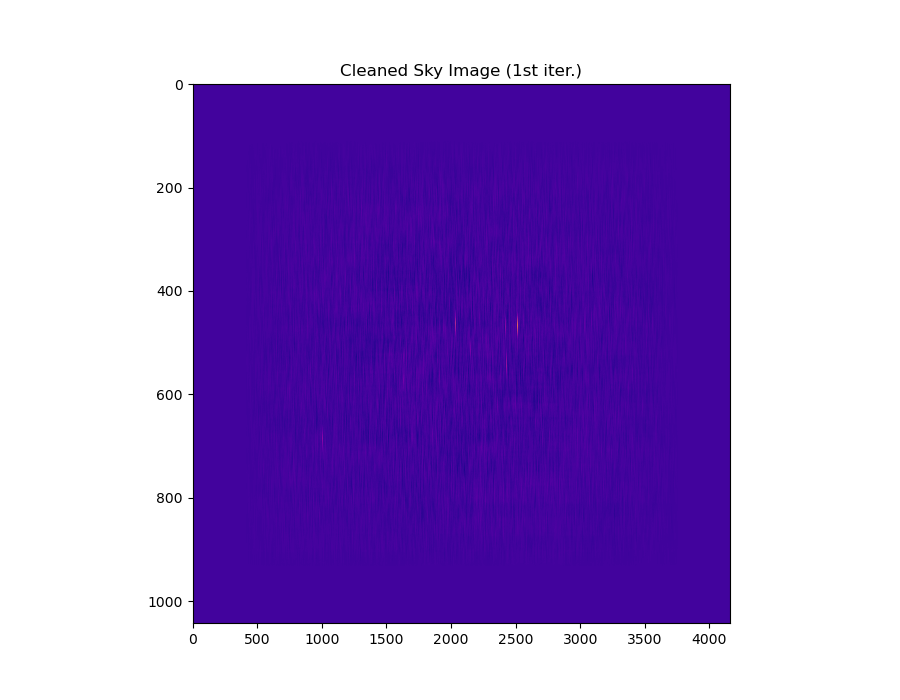

In [22]:
plt.figure(figsize=(9, 7))
plt.title("Cleaned Sky Image (1st iter.)")
plt.imshow(skydiff.T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

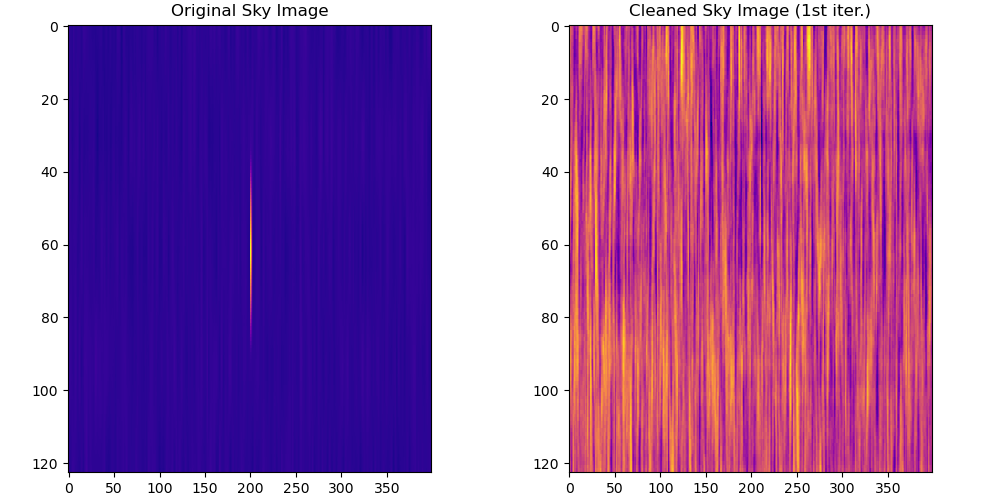

In [23]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))
vmin, vmax = np.min(skysim),np.max(skysim)
axs[0].set_title('Original Sky Image')
axs[0].imshow(skysim[peak_p[0] - 100*xspan:peak_p[0] + 100*xspan - 1 , peak_p[1]-2*yspan: peak_p[1]+2*yspan -1].T, cmap=cm.plasma, vmin=vmin, vmax=vmax, interpolation='nearest', aspect=ELYDIM/ELXDIM)

axs[1].set_title('Cleaned Sky Image (1st iter.)')
axs[1].imshow(skydiff[peak_p[0] - 100*xspan:peak_p[0] + 100*xspan - 1 , peak_p[1]-2*yspan: peak_p[1]+2*yspan -1].T, cmap=cm.plasma,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()